The `CascModel` class provides an interface for loading and manipulating pre-generated IGMF cascade models.  This class reweights and interpolates IGMF model tables to generate models for an arbitrary choice of IGMF parameters, source geometry, and intrinisc SED.  To construct an instance you can call the `create_from_fits` method on a IGMF table FITS file.   

In [3]:
%matplotlib inline
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.cm
from fermipy.spectrum import PLExpCutoff, PowerLaw
from haloanalysis.model import make_prim_model, make_casc_model
from haloanalysis.model import CascModel
from haloanalysis.utils import Axis
import numpy as np

cm0 = CascModel.create_from_fits('results_th_jet6.00_z0.13_tmax1e+07.fits.gz')

axis_eobs = cm0.axes[1]

emin = 10**axis_eobs.lo
emax = 10**axis_eobs.hi
ectr = 10**axis_eobs.centers
deltae = emax-emin
efct = ectr**2/deltae

The `CascModel` class provides the following methods for evaluating the spectral/spatial model of a source:
* `prim_flux` : computes the flux vs. energy for the EBL-absorbed primary component
* `casc_flux` : computes the flux vs. energy for the cascade component
* `casc_r68` : computes the width vs. energy for the cascade component

These methods accept the following input arguments:
* `inj_spectrum` : spectral function object representing the model for the injection (i.e. unabsorbed) SED
* `p0` : Parameters of the IGMF model (e.g. Lcoh and B)
* `p1` : Parameters of the chosen model for the injection spectrum


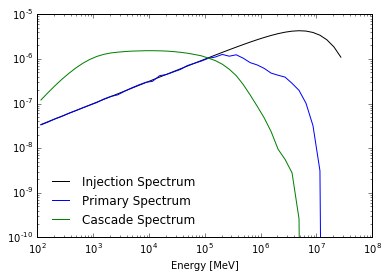

In [4]:
# Injection spectrum
inj_spec = PLExpCutoff([1E-13,-1.5,10E6],scale=1E3)
#inj_spec = PowerLaw([1E-13,-1.5],scale=1E3)

axis_eobs = Axis('eobs',np.linspace(2,6,33))

inj_flux = inj_spec.flux(emin,emax)
prim_flux = cm0.prim_flux(inj_spec,[0.0,-16.0])
casc_flux = cm0.casc_flux(inj_spec,[0.0,-16.0])

plt.figure()

plt.loglog(ectr,inj_flux*efct,label='Injection Spectrum',color='k')
plt.loglog(ectr,prim_flux*efct,label='Primary Spectrum',color='b')
plt.loglog(ectr,casc_flux*efct,label='Cascade Spectrum',color='g')

plt.gca().set_ylim(1E-10)
plt.gca().legend(frameon=False,loc='lower left')
plt.gca().set_xlabel('Energy [MeV]')


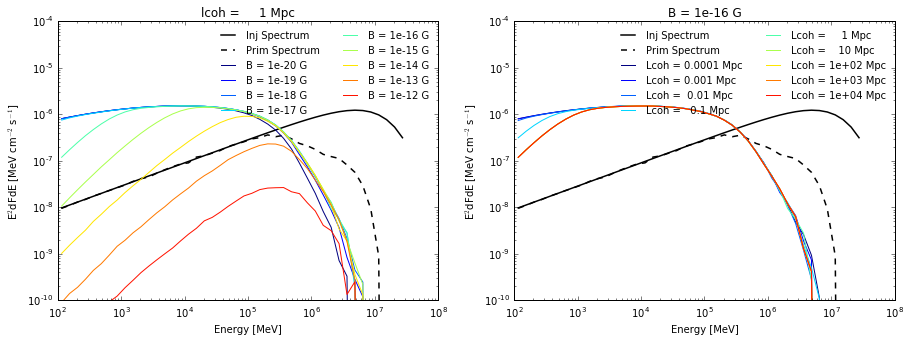

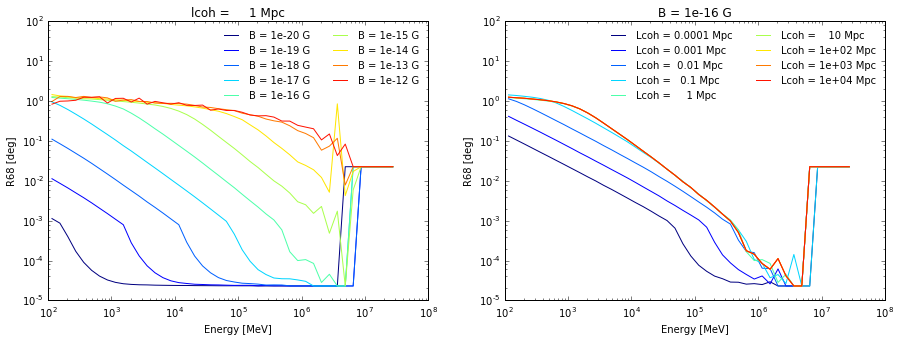

In [5]:
inj_spec = PLExpCutoff([1E-13,-1.5,10E6],scale=1E3)

nstep = 9
igmf_val = np.linspace(-20,-12,nstep)
lcoh_val = np.linspace(-4,4,nstep)

prim_flux = cm0.prim_flux(inj_spec,[0.0,-16.0])
inj_flux = inj_spec.flux(emin,emax)

# Cascade Flux at Constant Lcoh

casc_flux = cm0.casc_flux(inj_spec,[0.0,igmf_val])

fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)

plt.loglog(ectr,inj_flux*ectr,color='k',linewidth=1.5,label='Inj Spectrum')
plt.loglog(ectr,prim_flux*ectr,color='k',linewidth=1.5,linestyle='--',label='Prim Spectrum')

for i in range(casc_flux.shape[1]):

    plt.loglog(ectr,casc_flux[:,i]*efct,color=matplotlib.cm.jet(float(i)/float(nstep)),
               label='B = %5.2g G'%10**igmf_val[i])
    
plt.gca().set_ylim(1E-10,1E-4)
plt.gca().set_title('lcoh = %5.2g Mpc'%1.0)
plt.gca().legend(frameon=False,loc='upper right',prop={'size':10},ncol=2)
plt.gca().set_xlabel('Energy [MeV]')
plt.gca().set_ylabel('E$^{2}$dFdE [MeV cm$^{-2}$ s$^{-1}$]')

# Cascade Flux at Constant Bfield
fig.add_subplot(122)

casc_flux = cm0.casc_flux(inj_spec,[lcoh_val,-16.0])
               
plt.loglog(ectr,inj_flux*ectr,color='k',linewidth=1.5,label='Inj Spectrum')
plt.loglog(ectr,prim_flux*ectr,color='k',linewidth=1.5,linestyle='--',label='Prim Spectrum')

for i in range(casc_flux.shape[1]):

    plt.loglog(ectr,casc_flux[:,i]*efct,color=matplotlib.cm.jet(float(i)/float(nstep)),
               label='Lcoh = %5.2g Mpc'%10**lcoh_val[i])
    
plt.gca().set_ylim(1E-10,1E-4)
plt.gca().set_title('B = %5.2g G'%10**-16.0)
plt.gca().legend(frameon=False,loc='upper right',prop={'size':10},ncol=2)
plt.gca().set_xlabel('Energy [MeV]')
plt.gca().set_ylabel('E$^{2}$dFdE [MeV cm$^{-2}$ s$^{-1}$]')



# R68 at Constant Lcoh
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)

casc_r68 = cm0.casc_r68(inj_spec,[0.0,igmf_val])

for i in range(casc_r68.shape[1]):

    plt.loglog(ectr,casc_r68[:,i],color=matplotlib.cm.jet(float(i)/9.),
               label='B = %5.2g G'%10**igmf_val[i])
    
plt.gca().set_ylim(1E-5,100)
plt.gca().set_title('lcoh = %5.2g Mpc'%1.0)
plt.gca().legend(frameon=False,loc='best',prop={'size':10},ncol=2)
plt.gca().set_xlabel('Energy [MeV]')
plt.gca().set_ylabel('R68 [deg]')

# R68 at Constant Bfield

casc_r68 = cm0.casc_r68(inj_spec,[lcoh_val,-16.0])

fig.add_subplot(122)
for i in range(casc_r68.shape[1]):

    plt.loglog(ectr,casc_r68[:,i],color=matplotlib.cm.jet(float(i)/9.),
               label='Lcoh = %5.2g Mpc'%10**lcoh_val[i])
    
plt.gca().set_ylim(1E-5,100)
plt.gca().set_title('B = %5.2g G'%10**-16.0)
plt.gca().legend(frameon=False,loc='upper right',prop={'size':10},ncol=2)
plt.gca().set_xlabel('Energy [MeV]')
plt.gca().set_ylabel('R68 [deg]')
    

In [6]:
import os
if not os.path.isfile('results_th_jet6.00_tmax1e+07.fits.gz'):
    !curl -OL https://www.dropbox.com/s/v03oh5ipaeuazaw/results_th_jet6.00_tmax1e%2B07.fits.gz?dl=0

cm1 = CascModel.create_from_fits('results_th_jet6.00_tmax1e+07.fits.gz')

/Users/mdwood/fermi/ext_analysis/haloanalysis/haloanalysis/model.py:679: RuntimeWarning: invalid value encountered in divide
  data_casc_flux = np.array(tab_casc_flux/tab_inj_flux[..., np.newaxis, np.newaxis])
/Users/mdwood/fermi/ext_analysis/haloanalysis/haloanalysis/model.py:680: RuntimeWarning: invalid value encountered in divide
  data_prim_flux = np.array(tab_prim_flux/tab_inj_flux)
/Users/mdwood/fermi/ext_analysis/haloanalysis/haloanalysis/utils.py:104: RuntimeWarning: divide by zero encountered in log
  self._fn = RegularGridInterpolator(points, np.log(data),


/Users/mdwood/anaconda2/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:1816: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]


(100.0, 100000.0)

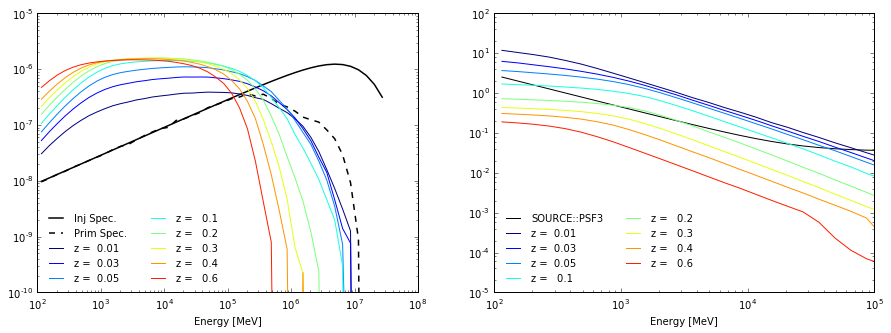

In [7]:
redshift_val = [0.01,0.03,0.05,0.1,0.2,0.3,0.4,0.6]

casc_flux = cm1.casc_flux(inj_spec,[redshift_val,0.0,-16.0])
casc_r68 = cm1.casc_r68(inj_spec,[redshift_val,0.0,-16.0])

fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)

plt.loglog(ectr,inj_flux*ectr,color='k',linewidth=1.5,label='Inj Spec.')
plt.loglog(ectr,prim_flux*ectr,color='k',linewidth=1.5,linestyle='--',label='Prim Spec.')

for i in range(casc_flux.shape[1]):
    plt.loglog(ectr,casc_flux[:,i]*efct,color=matplotlib.cm.jet(float(i)/len(redshift_val)),
               label='z = %5.2g'%redshift_val[i])
    
plt.gca().set_ylim(1E-10)
plt.gca().legend(frameon=False,loc='lower left',prop={'size':10},ncol=2)
plt.gca().set_xlabel('Energy [MeV]')

fig.add_subplot(122)

plt.loglog(ectr,np.sqrt((2.85*(ectr/100.)**-0.8)**2+0.035**2),color='k',label='SOURCE::PSF3')

for i in range(casc_r68.shape[1]):
    plt.loglog(ectr,casc_r68[:,i],color=matplotlib.cm.jet(float(i)/casc_r68.shape[1]),
               label='z = %5.2g'%redshift_val[i])
    
plt.gca().legend(frameon=False,loc='lower left',prop={'size':10},ncol=2)
plt.gca().set_xlabel('Energy [MeV]')

plt.gca().set_xlim(1E2,1E5)